# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [3]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [43]:
recommender = MainRecommender(data_train_lvl_1)

In [6]:
recommender.get_als_recommendations(2375, N=5)

[871756, 899624, 1044078, 1106523, 844179]

In [7]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [8]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1042907, 917816, 1133312, 1115576]

In [9]:
recommender.get_similar_users_recommendation(2375, N=5)

[950894, 5574377, 7168057, 1012801, 979674]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов(товаров). Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [ ]:
result_lvl_1[]

In [59]:
result_user = list(result_lvl_1.loc[result_lvl_1['user_id'] == 2375, 'actual'])[0]
print(result_user)

[  835300   848029   862714   896613   923746   932464   943414   957951
   964120   968072   970792   996506  1003793  1036501  1115259  1125530
  1133018  1136353  7441558  9836719 15926887 14110697   920581  1050626
   883932   847962   903233  1052920  1054383  1112766  7167967 10150063
 15716445 12171843 15741839 10285144 13910920   965766  1004906  1041796
  9242345 15927606   845208   860776   864312   882247   888404   900802
   938687   949151   951954   962568   986021   989069  1008602  1055646
  1072685  1077285  1079023  5563693  5585510  6979717  7168456  8065410
 14025185  1100972  1092118  9245445]


In [57]:
recomender_user = recommender.get_als_recommendations(2375, N=50)
print(recomender_user)

[899624, 1044078, 871756, 1106523, 844179, 8090537, 5569230, 865456, 1022428, 1046545, 832678, 1051323, 1025535, 883932, 9835223, 850102, 947858, 854852, 823704, 8090521, 5585510, 1081177, 1004390, 999779, 6534480, 5569845, 870547, 6533765, 823990, 944534, 1133312, 925862, 865528, 896862, 999714, 9836106, 937292, 8065410, 1029743, 1004906, 1006878, 1038663, 965766, 998556, 12262978, 1059902, 826666, 1131344, 999270, 1000753]


In [60]:
recal = []
recal.append(recall_at_k(recomender_user, result_user, k=20))
print(recal)

[0.014705882352941176]


In [61]:
recal.append(recall_at_k(recomender_user, result_user, k=50))
print(recal)

[0.014705882352941176, 0.07352941176470588]


In [62]:
recal.append(recall_at_k(recomender_user, result_user, k=100))
print(recal)

[0.014705882352941176, 0.07352941176470588, 0.07352941176470588]


**Значение k=50 наиболее оптимально**

In [65]:
recal.append(recall_at_k(recomender_user, result_user, k=200))
print(recal)

[0.014705882352941176, 0.07352941176470588, 0.07352941176470588, 0.07352941176470588]


In [66]:
recal.append(recall_at_k(recomender_user, result_user, k=500))
print(recal)

[0.014705882352941176, 0.07352941176470588, 0.07352941176470588, 0.07352941176470588, 0.07352941176470588]


In [22]:
recommended_list_own = recommender.get_own_recommendations(2375, N=50)

In [67]:
recall_at_k(recommended_list_own, result_user, k=50)

0.08823529411764706

In [69]:
recomender_similar_items = recommender.get_similar_items_recommendation(2375, N=50)

In [70]:
recall_at_k(recomender_similar_items, result_user, k=50)

0.0

In [71]:
recall_at_k(recommender.get_similar_users_recommendation(2375, N=50), data_val_lvl_1, k=100)

0.002298024288349017

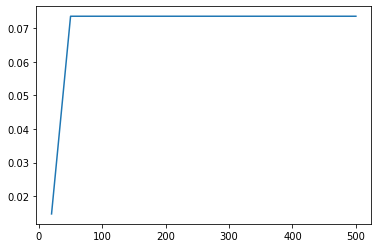

In [72]:
plt.plot([20, 50, 100, 200, 500], recal)
plt.show()

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [73]:
# your_code
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [74]:
users_lvl_2.head()

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."
2,1753,"[967041, 963686, 948640, 1057168, 942475, 9553..."
3,2120,"[5707857, 1029743, 1106523, 5569230, 916122, 8..."
4,1346,"[1135983, 5569309, 1129982, 5574377, 5569993, ..."


In [79]:
data_train_lvl_2.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0
2107472,2021,40618753059,594,951590,1,1.69,443,-0.60,101,86,0.0,0.0
2107473,2021,40618753059,594,1019142,2,5.00,443,-1.98,101,86,0.0,0.0
2107474,2021,40618753059,594,1051489,2,2.50,443,-0.68,101,86,0.0,0.0
2107475,2021,40618753059,594,1111839,1,0.59,443,0.00,101,86,0.0,0.0
2107476,2021,40618753059,594,9835223,1,9.27,443,-3.63,101,86,0.0,0.0


In [81]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})
df.head(10)

,user_id,item_id
0,2070,1105426
1,2070,1097350
2,2070,879194
3,2070,948640
4,2070,928263
5,2070,944588
6,2070,1032703
7,2070,10198378
8,2070,1138596
9,2070,1092937


In [82]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id', 'quantity', 'sales_value']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2.head()

,user_id,item_id,quantity,sales_value,target
2104867,2070,1019940,1,1.00,1
2107468,2021,840361,1,0.99,1
2107469,2021,856060,1,1.77,1
2107470,2021,869344,1,1.67,1
2107471,2021,896862,2,5.00,1


In [83]:
targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2.head(10)

,user_id,item_id,quantity,sales_value,target
0,2070,1105426,NaN,NaN,NaN
1,2070,1097350,NaN,NaN,NaN
2,2070,879194,NaN,NaN,NaN
3,2070,948640,NaN,NaN,NaN
4,2070,928263,NaN,NaN,NaN
5,2070,944588,NaN,NaN,NaN
6,2070,1032703,NaN,NaN,NaN
7,2070,10198378,NaN,NaN,NaN
8,2070,1138596,NaN,NaN,NaN
9,2070,1092937,1.0,3.29,1.0


In [85]:
targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2['quantity'].fillna(0, inplace= True)
targets_lvl_2['sales_value'].fillna(0, inplace= True)

targets_lvl_2.head()

,user_id,item_id,quantity,sales_value,target
0,2070,1105426,0.0,0.0,0.0
1,2070,1097350,0.0,0.0,0.0
2,2070,879194,0.0,0.0,0.0
3,2070,948640,0.0,0.0,0.0
4,2070,928263,0.0,0.0,0.0


In [86]:
targets_lvl_2.head(10)

,user_id,item_id,quantity,sales_value,target
0,2070,1105426,0.0,0.00,0.0
1,2070,1097350,0.0,0.00,0.0
2,2070,879194,0.0,0.00,0.0
3,2070,948640,0.0,0.00,0.0
4,2070,928263,0.0,0.00,0.0
5,2070,944588,0.0,0.00,0.0
6,2070,1032703,0.0,0.00,0.0
7,2070,10198378,0.0,0.00,0.0
8,2070,1138596,0.0,0.00,0.0
9,2070,1092937,1.0,3.29,1.0


In [87]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,quantity,sales_value,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,0.0,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,0.0,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [88]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]
X_train.head()

,user_id,item_id,quantity,sales_value,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [89]:
cat_feats = X_train.columns[4:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [90]:
from lightgbm import LGBMRanker

lgb_params = { 
    'objective':'lambdarank',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 4,
    'categorical_column': cat_feats,
    'random_state': 27,
    'verbose': 1,
    'is_unbalance': True
}

In [91]:
X_train['num'] = np.arange(len(X_train))
gr = X_train[['user_id', 'num']].groupby('user_id', sort=False).max()['num'].values
grs = np.concatenate((np.array([gr[0]+1]), gr[1:] - gr[:-1]))

In [92]:
X_train.shape

(111366, 18)

In [93]:
y_train.shape

(111366, 1)

In [94]:
np.sum(grs)

111366

In [95]:
lgb = LGBMRanker(**lgb_params, silent=False)
lgb.fit(X_train, y_train, group=grs,
        eval_set=[(X_train, y_train)], eval_group=[grs], 
        
        eval_metric=['ndcg'],
        eval_at=[5, 10 ], early_stopping_rounds=50)

#train_preds = lgb.predict_proba(X_train)

[1]	training's ndcg@5: 0.999742	training's ndcg@10: 0.99967
Training until validation scores don't improve for 50 rounds
[2]	training's ndcg@5: 0.999742	training's ndcg@10: 0.99967
[3]	training's ndcg@5: 1	training's ndcg@10: 0.999963
[4]	training's ndcg@5: 1	training's ndcg@10: 1
[5]	training's ndcg@5: 1	training's ndcg@10: 1
[6]	training's ndcg@5: 1	training's ndcg@10: 1
[7]	training's ndcg@5: 1	training's ndcg@10: 1
[8]	training's ndcg@5: 1	training's ndcg@10: 1
[9]	training's ndcg@5: 1	training's ndcg@10: 1
[10]	training's ndcg@5: 1	training's ndcg@10: 1
[11]	training's ndcg@5: 1	training's ndcg@10: 1
[12]	training's ndcg@5: 1	training's ndcg@10: 1
[13]	training's ndcg@5: 1	training's ndcg@10: 1
[14]	training's ndcg@5: 1	training's ndcg@10: 1
[15]	training's ndcg@5: 1	training's ndcg@10: 1
[16]	training's ndcg@5: 1	training's ndcg@10: 1
[17]	training's ndcg@5: 1	training's ndcg@10: 1
[18]	training's ndcg@5: 1	training's ndcg@10: 1
[19]	training's ndcg@5: 1	training's ndcg@10: 1
[20

[176]	training's ndcg@5: 1	training's ndcg@10: 1
[177]	training's ndcg@5: 1	training's ndcg@10: 1
[178]	training's ndcg@5: 1	training's ndcg@10: 1
[179]	training's ndcg@5: 1	training's ndcg@10: 1
[180]	training's ndcg@5: 1	training's ndcg@10: 1
[181]	training's ndcg@5: 1	training's ndcg@10: 1
[182]	training's ndcg@5: 1	training's ndcg@10: 1
[183]	training's ndcg@5: 1	training's ndcg@10: 1
[184]	training's ndcg@5: 1	training's ndcg@10: 1
[185]	training's ndcg@5: 1	training's ndcg@10: 1
[186]	training's ndcg@5: 1	training's ndcg@10: 1
[187]	training's ndcg@5: 1	training's ndcg@10: 1
[188]	training's ndcg@5: 1	training's ndcg@10: 1
[189]	training's ndcg@5: 1	training's ndcg@10: 1
[190]	training's ndcg@5: 1	training's ndcg@10: 1
[191]	training's ndcg@5: 1	training's ndcg@10: 1
[192]	training's ndcg@5: 1	training's ndcg@10: 1
[193]	training's ndcg@5: 1	training's ndcg@10: 1
[194]	training's ndcg@5: 1	training's ndcg@10: 1
[195]	training's ndcg@5: 1	training's ndcg@10: 1
[196]	training's ndc

[346]	training's ndcg@5: 1	training's ndcg@10: 1
[347]	training's ndcg@5: 1	training's ndcg@10: 1
[348]	training's ndcg@5: 1	training's ndcg@10: 1
[349]	training's ndcg@5: 1	training's ndcg@10: 1
[350]	training's ndcg@5: 1	training's ndcg@10: 1
[351]	training's ndcg@5: 1	training's ndcg@10: 1
[352]	training's ndcg@5: 1	training's ndcg@10: 1
[353]	training's ndcg@5: 1	training's ndcg@10: 1
[354]	training's ndcg@5: 1	training's ndcg@10: 1
[355]	training's ndcg@5: 1	training's ndcg@10: 1
[356]	training's ndcg@5: 1	training's ndcg@10: 1
[357]	training's ndcg@5: 1	training's ndcg@10: 1
[358]	training's ndcg@5: 1	training's ndcg@10: 1
[359]	training's ndcg@5: 1	training's ndcg@10: 1
[360]	training's ndcg@5: 1	training's ndcg@10: 1
[361]	training's ndcg@5: 1	training's ndcg@10: 1
[362]	training's ndcg@5: 1	training's ndcg@10: 1
[363]	training's ndcg@5: 1	training's ndcg@10: 1
[364]	training's ndcg@5: 1	training's ndcg@10: 1
[365]	training's ndcg@5: 1	training's ndcg@10: 1
[366]	training's ndc

LGBMRanker(boosting_type='gbdt',
           categorical_column=['manufacturer', 'department', 'brand',
                               'commodity_desc', 'sub_commodity_desc',
                               'curr_size_of_product', 'age_desc',
                               'marital_status_code', 'income_desc',
                               'homeowner_desc', 'hh_comp_desc',
                               'household_size_desc', 'kid_category_desc'],
           class_weight=None, colsample_bytree=1.0, importance_type='split',
           is_unbalance=True, learning_rate=0.1, max_depth=4,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=500, n_jobs=-1, num_leaves=31, objective='lambdarank',
           random_state=27, reg_alpha=0.0, reg_lambda=0.0, silent=False,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
           verbose=1)

In [99]:
train_preds = lgb.predict(X_train)

In [100]:
train_preds

array([-0.50526121, -0.50526121, -0.50526121, ..., -0.51443757,
       -0.51443757, -0.51443757])

In [101]:
X_train["predicted_ranking"] = train_preds
X_train.sort_values("predicted_ranking", ascending=False)
X_train.head()

,user_id,item_id,quantity,sales_value,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,num,predicted_ranking
0,2070,1105426,0.0,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0,-0.505261
1,2070,1097350,0.0,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1,-0.505261
2,2070,879194,0.0,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2,-0.505261
3,2070,948640,0.0,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3,-0.505261
4,2070,928263,0.0,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4,-0.505261


### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 